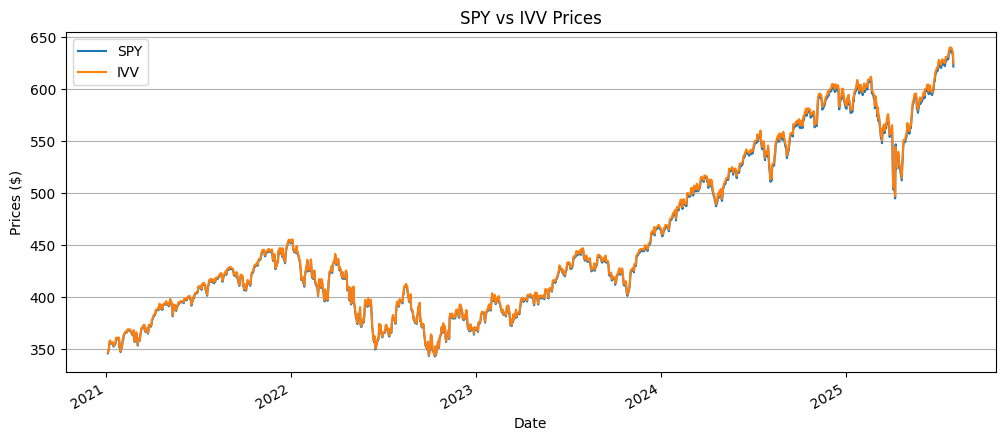

In [63]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Dowload Close prices
spy_ticker = yf.Ticker("SPY")
ivv_ticker = yf.Ticker("IVV")
spy = spy_ticker.history(start="2021-01-01", auto_adjust=True)
ivv = ivv_ticker.history(start="2021-01-01", auto_adjust=True)

# Compine the series in one dataframe
prices = pd.DataFrame({"SPY": spy["Close"], "IVV": ivv["Close"]}).dropna()

# Plot the series
prices.plot(title="SPY vs IVV Prices", figsize=(12,5))
plt.ylabel("Prices ($)")
plt.grid(True, axis="y")
plt.show()



<function matplotlib.pyplot.show(close=None, block=None)>

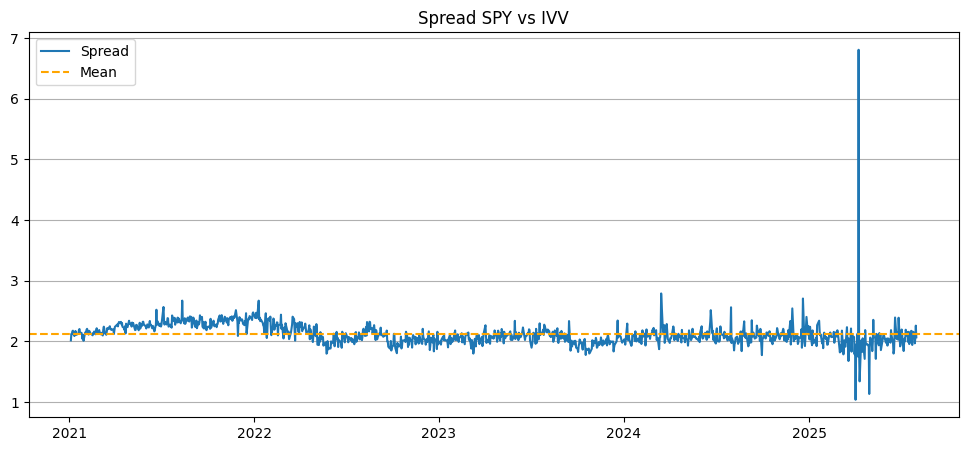

In [64]:
hedge_ratio = 0.992
spread = prices["SPY"] - hedge_ratio * prices["IVV"]

plt.figure(figsize=(12,5))
plt.plot(spread, label="Spread")
plt.title("Spread SPY vs IVV")
plt.axhline(spread.mean(), color="orange", linestyle="--", label="Mean")
plt.grid(True, axis="y")
plt.legend()
plt.show

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

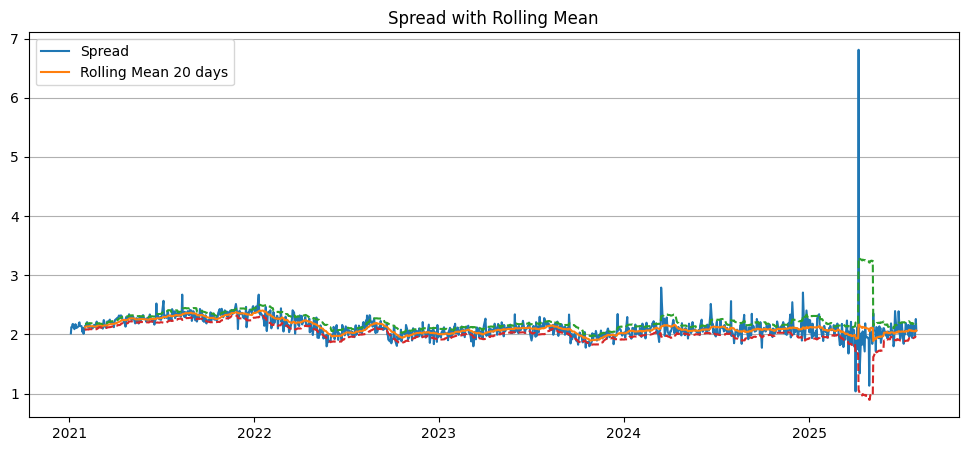

In [65]:
window = 20

rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()
upper_band = rolling_mean + (rolling_std * 1)
lower_band = rolling_mean - (rolling_std * 1)

plt.figure(figsize=(12,5))
plt.plot(spread, label="Spread")
plt.plot(rolling_mean, label=f"Rolling Mean {window} days")
plt.plot(upper_band, linestyle="--")
plt.plot(lower_band, linestyle="--")
plt.title("Spread with Rolling Mean")
plt.legend()
plt.grid(True, axis="y")
plt.plot

[]

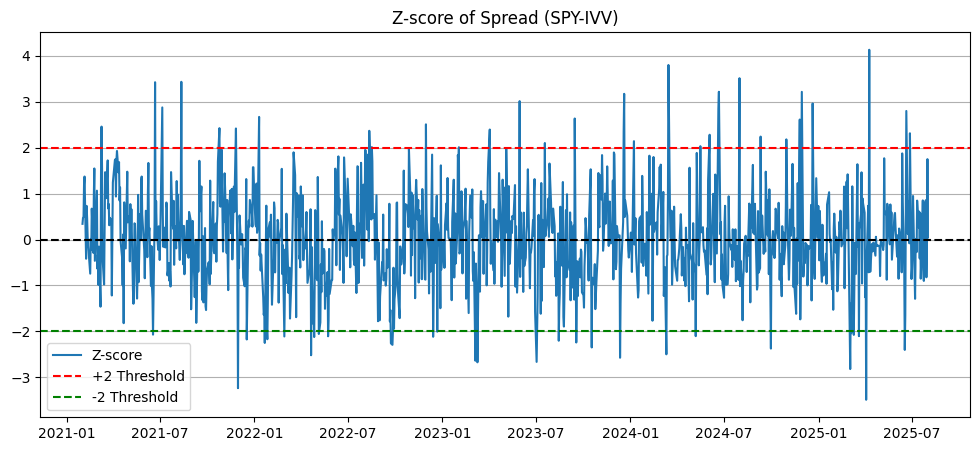

In [66]:
z_score = (spread - rolling_mean) / rolling_std

plt.figure(figsize=(12,5))
plt.plot(z_score, label="Z-score")
plt.axhline(0, color="black", linestyle="--")
plt.axhline(2, color="red", linestyle="--", label="+2 Threshold")
plt.axhline(-2, color="green", linestyle="--", label="-2 Threshold")
plt.title("Z-score of Spread (SPY-IVV)")
plt.legend()
plt.grid(True, axis="y")
plt.plot()

[]

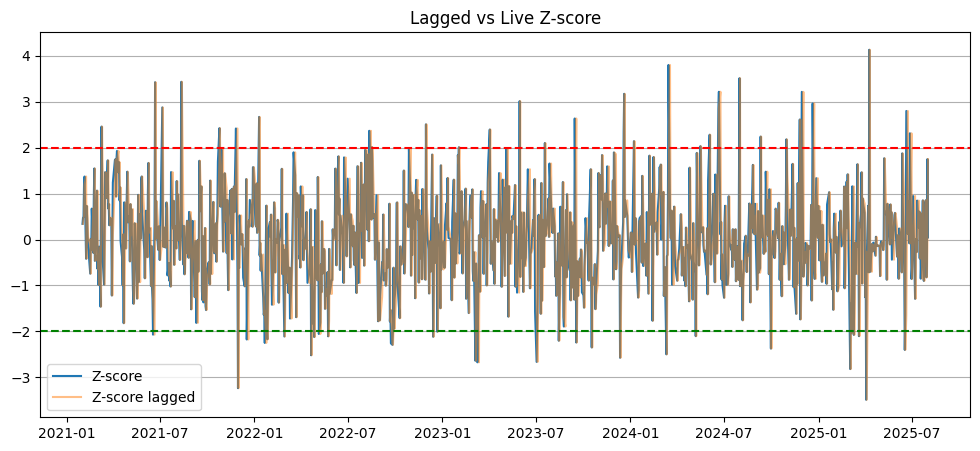

In [67]:
z_score_lagged = z_score.shift(1)

entry_long = z_score_lagged < -1.64 # 1.64 = 90% confidence level
entry_short = z_score_lagged > 1.64
exit_signal = (z_score_lagged > -1.28) & (z_score_lagged < 1.28) # 1.28 = 80% confidence level

plt.figure(figsize=(12,5))
plt.plot(z_score, label="Z-score")
plt.plot(z_score_lagged, label="Z-score lagged", alpha=0.5)
plt.axhline(2, color="red", linestyle="--")
plt.axhline(-2, color="green", linestyle="--")
plt.title("Lagged vs Live Z-score")
plt.legend()
plt.grid(True, axis="y")
plt.plot()

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

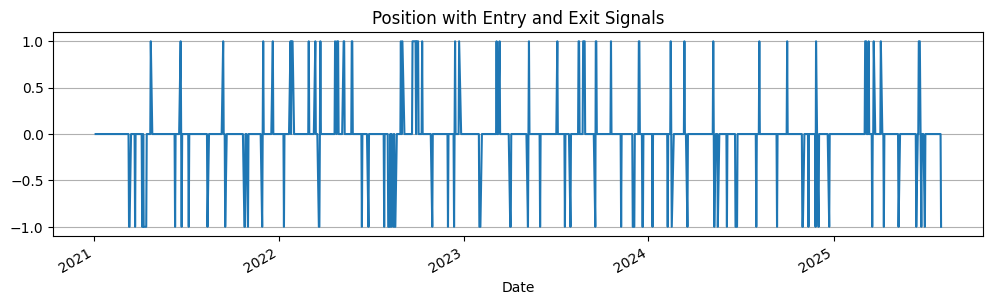

In [68]:
position = []
current_position = 0

for long, short, exit in zip(entry_long, entry_short, exit_signal):
    if exit:
        current_position = 0
    elif long:
        current_position = 1
    elif short:
        current_position = -1
    position.append(current_position)

position = pd.Series(position, index=spread.index)

position.plot(title="Position with Entry and Exit Signals", figsize=(12, 3))
plt.grid(True, axis="y")
plt.plot

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

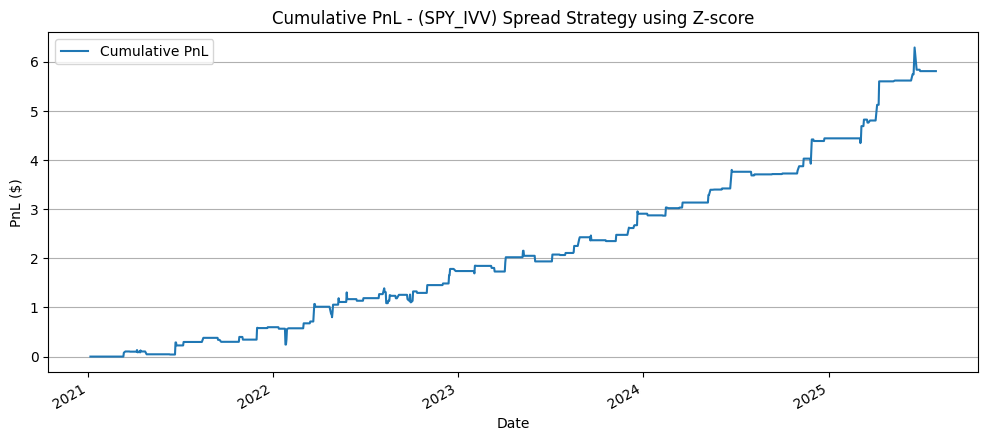

In [69]:
spread_return = spread.diff()

pnl = position.shift(1) * spread_return

cumulative_pnl = pnl.cumsum()

plt.figure(figsize=(12,5))
cumulative_pnl.plot(label='Cumulative PnL')
plt.title("Cumulative PnL - (SPY_IVV) Spread Strategy using Z-score")
plt.ylabel("PnL ($)")
plt.legend()
plt.grid(True, axis="y")
plt.plot

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

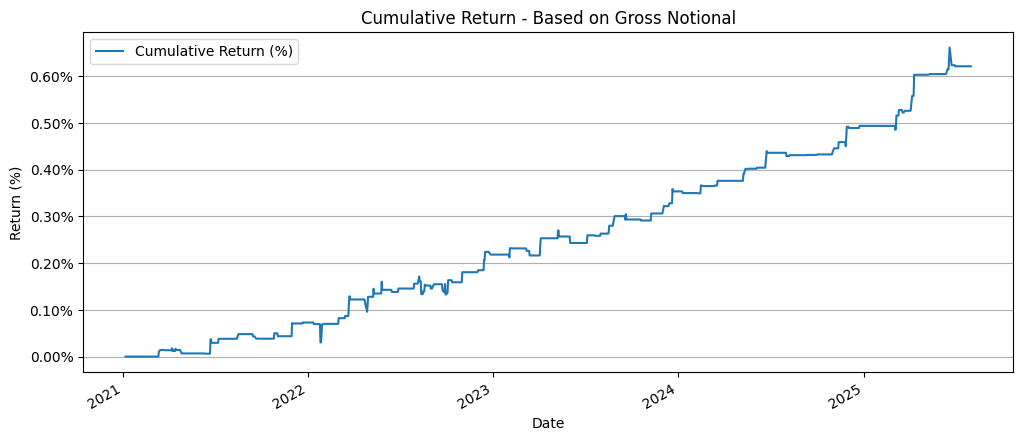

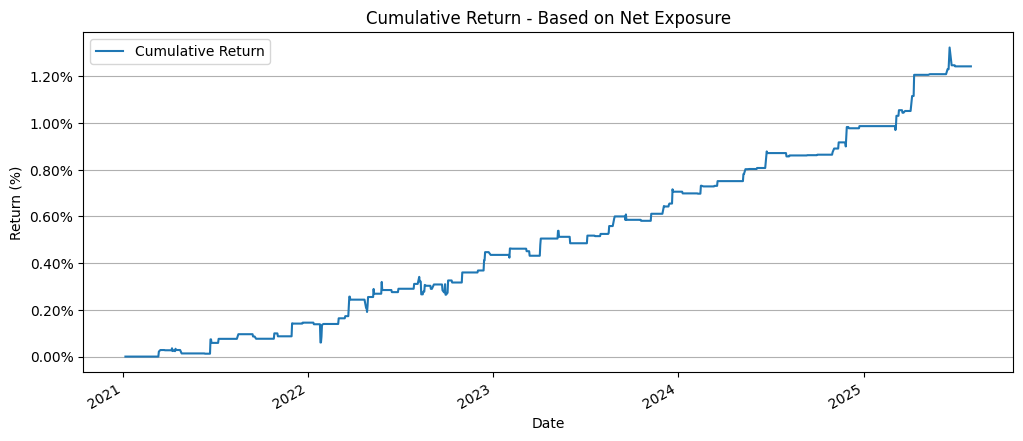

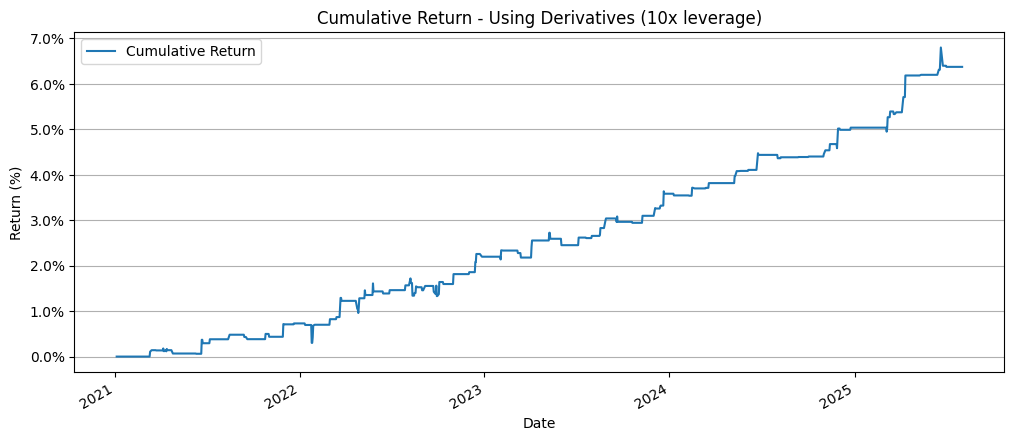

In [70]:
# Calculate returns (%)
# Based on gross notional (assuming we need cash for short and long positions, very conservative)
from matplotlib.ticker import PercentFormatter

notional = abs(prices["SPY"] + abs(hedge_ratio * prices["IVV"]))
daily_return_gross = pnl / notional
cumulative_return_gross = (1 + daily_return_gross).cumprod() -1

plt.figure(figsize=(12,5))
cumulative_return_gross.plot(label="Cumulative Return (%)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.title("Cumulative Return - Based on Gross Notional")
plt.ylabel("Return (%)")
plt.legend()
plt.grid(True, axis="y")
plt.plot


# Based on net exposure (assuming short leg finance long leg)
import numpy as np

exposure = np.maximum(abs(prices["SPY"]), abs(hedge_ratio * prices["IVV"]))
daily_return_net = pnl / exposure
cumulative_return_net = (1 + daily_return_net).cumprod() -1

plt.figure(figsize=(12,5))
cumulative_return_net.plot(label="Cumulative Return")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.title("Cumulative Return - Based on Net Exposure")
plt.ylabel("Return (%)")
plt.legend()
plt.grid(True, axis="y")
plt.plot

# Using derivatives (implying leverage)
margin_rate = 0.1 # 10% margin (10x leverage)
capital_required = notional * margin_rate
daily_return_margin = pnl / capital_required
cumulative_return_margin = (1 + daily_return_margin).cumprod() -1

plt.figure(figsize=(12,5))
cumulative_return_margin.plot(label="Cumulative Return")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.title("Cumulative Return - Using Derivatives (10x leverage)")
plt.ylabel("Return (%)")
plt.legend()
plt.grid(True, axis="y")
plt.plot

In [71]:
# Metrics (Margin scenario)
cumulated_return_margin = cumulative_return_margin.iloc[-1]
annualized_return_margin = daily_return_margin.mean() * 252
volatility = daily_return_margin.std() * (252 ** 0.5)
sharpe =  annualized_return_margin / volatility

roll_max = cumulative_return_margin.cummax()
daily_dd = cumulative_return_margin - roll_max
max_dd = daily_dd.min()

print(f"Performance Metrics (Margin Scenario, {int(1/margin_rate)}x Leverage)")
print(f"- Cumulated Return: {cumulated_return_margin:.2%}")
print(f"- Annualized Return: {annualized_return_margin:.2%}")
print(f"- Volatility: {volatility:.2%}")
print(f"- Sharpe Ratio: {sharpe:.2f}")
print(f"- Max Drawdown: {max_dd:.2%}")

# Metrics (Net exposure scenario)
cumulated_return_net = cumulative_return_net.iloc[-1]
annualized_return_net = daily_return_net.mean() * 252
volatility_net = daily_return_net.std() * (252 ** 0.5)
sharpe_net =  annualized_return_net / volatility_net

roll_max_net = cumulative_return_net.cummax()
daily_dd_net = cumulative_return_net - roll_max_net
max_dd_net = daily_dd_net.min()

print(f"\nPerformance Metrics (Net Exposure Scenario)")
print(f"- Cumulated Return: {cumulated_return_net:.2%}")
print(f"- Annualized Return: {annualized_return_net:.2%}")
print(f"- Volatility: {volatility_net:.2%}")
print(f"- Sharpe Ratio: {sharpe_net:.2f}")
print(f"- Max Drawdown: {max_dd_net:.2%}")

Performance Metrics (Margin Scenario, 10x Leverage)
- Cumulated Return: 6.37%
- Annualized Return: 1.36%
- Volatility: 0.79%
- Sharpe Ratio: 1.73
- Max Drawdown: -0.43%

Performance Metrics (Net Exposure Scenario)
- Cumulated Return: 1.24%
- Annualized Return: 0.27%
- Volatility: 0.16%
- Sharpe Ratio: 1.73
- Max Drawdown: -0.08%


### Return Calculation Logic with Fixed Notional (to use in the real backtest)

```python
capital = 50_000_000

# 1. Gross notional (conservative)
spread_unit_cost = abs(prices["SPY"]) + abs(hedge_ratio * prices["IVV"])
units = capital / spread_unit_cost

# 2. Net exposure (short leg fund long leg)
# spread_unit_cost_net = np.maximum(abs(prices["SPY"]), abs(hedge_ratio * prices["IVV"]))
# units_net = capital / spread_unit_cost_net

# 3. Using derivatives (implyin margin/leverage)
# margin_rate = 0.1
# spread_unit_cost_margin = abs(prices["SPY"]) + abs(hedge_ratio * prices["IVV"])
# units_margin = capital / (spread_unit_cost_margin * margin_rate)


spread_return = spread.diff()
pnl = position.shift(1) * units.shift(1) * spread_return

daily_return = pnl / capital
cumulative_return = (1 + daily_return).cumprod() - 1


In [72]:
# # Save prices data to .csv files for the backtest
# spy.to_csv("data/SPY.csv")
# ivv.to_csv("data/IVV.csv")